In [1]:
%load_ext autoreload
%autoreload 2

from importlib import reload

In [2]:
import re
import numpy as np
import scipy
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import quantstats as qs
# import pycountry
# from statsmodels.tsa.base.datetools import dates_from_str
import pandas as pd
# import modin.pandas as pd

import datatable as dt

import matplotlib.pyplot as plt
import seaborn as sb

from collections import defaultdict, Counter
import datetime
# import pandas_market_calendars as mcal

import funcs
# plt.rc('text', usetex=False)
plt.rcParams['figure.figsize'] =  [12, 4]

In [75]:
reload(funcs)

<module 'funcs' from 'c:\\Users\\lcota\\Dropbox\\prj\\Turnleaf_Analytics\\funcs.py'>

In [287]:
# def get_adj_close(sym):
#     return dfetfs.query(f"ticker=='{sym}'")['adjusted']

# def get_returns(sym):
#     if ticker in dfreturns:
#         return dfreturns[sym]
#     else:
#         return None


# Load & Filter CPI / ISM Data

In [95]:
dfcpi = pd.read_parquet("data/processed/cpi_all.pq")
dfcpi = funcs.filter_cols(dfcpi, "usa")
dfcpi.reset_index(inplace=True)
dfcpi['pubdate'] = dfcpi['usa.cpi.yoy.nsa.pubdate'].apply(funcs.adj_date)
dfcpi['index'] = dfcpi['pubdate'].copy()
# dfcpi['adjpubdate'] = dfcpi['usa.cpi.yoy.nsa.pubdate'].apply(funcs.adj_date)
dfcpi = dfcpi.set_index('index')

#######################################################################
# add US calendar adjusted publish date
#
dfism_man = pd.read_parquet("data/processed/ism_man.pq")
dfism_man = funcs.filter_cols(dfism_man, "usa")
dfism_man.reset_index(inplace=True)
dfism_man['pubdate'] = dfism_man['usa.ism.man.pubdate'].apply(funcs.adj_date)
dfism_man['index'] = dfism_man['pubdate'].copy()
dfism_man = dfism_man.set_index('index')

dfism_nonman = pd.read_parquet("data/processed/ism_nonman.pq")
dfism_nonman.reset_index(inplace=True)
dfism_nonman['pubdate'] = dfism_nonman['usa.ism.nonman.pubdate'].apply(funcs.adj_date)
dfism_nonman['index'] = dfism_nonman['pubdate'].copy()
dfism_nonman = dfism_nonman.set_index('index')
# dfism_nonman = funcs.filter_cols(dfism_nonman, "usa")
dfism_nonman = pd.read_parquet("data/processed/ism_nonman.pq")


In [105]:
# filter out rows where index is NaT
dfcpi = dfcpi[dfcpi['pubdate'].apply(lambda x: not pd.isna(x))]
dfism_man = dfism_man[dfism_man['pubdate'].apply(lambda x: not pd.isna(x))]
dfism_nonman = dfism_nonman[dfism_nonman['pubdate'].apply(lambda x: not pd.isna(x))]


# Filter ETFs 

In [4]:
dfetfs = pd.read_parquet("data/processed/etfs.pq")
df_total_returns = pd.read_parquet("data/processed/total_returns.pq")
dfetfref = pd.read_csv("data/processed/etfref.csv")
dfetfref.set_index('ticker', inplace=True)
idx = pd.DatetimeIndex(dfetfs.date.values)
dfetfs = dfetfs.set_index(idx)

In [49]:
mindate = datetime.date(2014, 1, 1) # minimum data date for analysis
mints = pd.Timestamp(pd.to_datetime(mindate)) # minimum timestamp for analysis 

# etfs2keep = pd.read_clipboard()['ticker'].values
etfs2keep = ['SPY', 'DIA', # broad index 
             'SPLG', 'SPYG', 'SPYV', 'SPSM', # specialty (growth, dividend, etc)
             'XBI', 'KRE', 'XOP', 'XME', 'KBE', 'XHB', 'KIE', 'XRT', # sector   
             'AGG', # all debt 
             'BIL', 'SPTS', 'SPTI', 'SPAB', 'TLT', 'SPTL', 'TMV', 'TMF', 'TBT', 'SHV', # USTs
             'FLOT', 'USFR', # floating rates
             'GLD', 'IAU', 'SLV', 'DBC', 'UNG', 'BOIL', 'DBO', # commods
             'VTIP', 'RINF', 'TIP', # Inflation
             'SPIB', 'SPSB', 'LQD', 'JNK', 'SJNK', 'SPHY' # credit 
            ] 

etfs2keep = ['SPY', 'AGG',  # sp500, Agg bond etf
            'XOP', 'XME', 'XHB', 'GLD',  # Oil & Gas, Metals & Mining, Homebuilders, Gold Shares
            'BIL', 'TIP', 'SPTS', 'SPTI'] # 1-3Mth TBills, TIPs, Short Term Tsy, Med. Term Tsy
# etfs2drop = ['SGOV', 'BKAG', 'BSJP', ] # remove b/c too little data
etfs2drop = ['USHY', 'GLDM', 'AAAU', 'BSCO']



# df_total_returns.to_parquet("data/processed/total_returns_filtered.pq")

In [180]:
dfcloses = dfetfs[dfetfs['date'].apply(pd.to_datetime) > mints]
dfcloses = dfcloses.pivot(columns='ticker', values='adjusted')[etfs2keep].dropna()

df_total_returns = dfcloses.pct_change().dropna().apply(lambda x: 100*np.cumprod(1 + x))

# Monthly volatilities (STDevs) -- maybe this is the forecast target? 
stdev_30d = df_total_returns.pct_change().rolling(window=30, min_periods=30).std().dropna().apply(lambda x: np.round(x * 100 * np.sqrt(252), 2))

# Generate Trade Returns (month-month) & CPI Diff matrices  

## Create Trade Entry/Exit dates for CPI data  
Trading Rule: BLS releases US CPI data at 8:30am on the publish date, so try variations of a simple trading rule.  
1. Enter trade on same day at Mids,  Exit trade on business day prior to next CPI release date.
2. Enter trade on same day at Mids, exit trade 1 week later.
3. Enter trade on same day at mids, exit trade 2 weeks later.
4. Enter trade on same day at open, exit trade at close.
5. Model relationship between prior day close and CPI day open to look for CPI release effect

In [187]:
dfcpi['cpi.yoy.diff'] = dfcpi['usa.cpi.yoy.nsa.realised'].diff()
dfcpi['cpi.mom.diff'] = dfcpi['usa.cpi.mom.nsa.realised'].diff()

df_cpi_diffs = dfcpi[['cpi.yoy.diff', 'cpi.mom.diff', 'pubdate']].copy().dropna()


dftrades_cpi = funcs.get_trade_dates(dfcpi)
dftrades_ism = funcs.get_trade_dates(dfism_man)
dftrades_nonism = funcs.get_trade_dates(dfism_nonman)

In [193]:
etfs2keep

['SPY', 'AGG', 'XOP', 'XME', 'XHB', 'GLD', 'BIL', 'TIP', 'SPTS', 'SPTI']

In [194]:
funcs.get_trade_prices(dfetfs, tickers=etfs2keep, dates=dftrades_cpi['entry'])

ticker,SPY,AGG,XOP,XME,XHB,GLD,BIL,TIP,SPTS,SPTI
2018-02-20,245.450882,91.935394,119.802513,34.100624,40.067307,126.239998,82.632614,92.398727,26.818762,26.571127
2018-03-16,248.976303,92.146790,122.161072,33.426319,39.323406,124.599998,82.704010,92.795776,26.834164,26.638361
2018-04-16,242.738235,92.459930,133.624802,32.395706,38.206367,127.629997,82.817039,93.716072,26.854031,26.668282
2018-05-15,246.161469,91.342445,148.886047,33.718170,36.720146,122.480003,82.914001,92.817093,26.784094,26.437786
2018-06-15,252.766647,92.069618,143.700531,33.995953,38.788498,121.339996,83.037315,93.638252,26.864952,26.667252
...,...,...,...,...,...,...,...,...,...,...
2023-07-14,445.892975,96.301781,127.433311,51.311417,83.133575,181.429993,89.210464,105.682091,28.243347,27.864115
2023-08-11,442.290314,94.720024,146.922974,50.694408,82.874718,177.600006,89.565666,104.575874,28.255207,27.520481
2023-09-15,441.579651,94.401741,148.275604,53.072887,78.553764,178.339996,90.011406,104.221046,28.305227,27.407406
2023-10-16,434.279266,92.311028,148.922668,50.834644,75.080673,177.960007,90.389442,102.635223,28.355619,27.105669


## Actual CPI Differences (MoM, YoY)

## Construct Monthly returns in between CPI release dates per etf

In [145]:
dfret1w = funcs.calc_returns(df_cpi_diffs, 
                             dfcloses, 
                             pd.DataFrame(index=pd.DatetimeIndex(dftrades_cpi['entry'])), 
                             pd.DataFrame(index=pd.DatetimeIndex(dftrades_cpi['trd.exit1w'])))

dfret2w = funcs.calc_returns(df_cpi_diffs, 
                             dfcloses, 
                             pd.DataFrame(index=pd.DatetimeIndex(dftrades_cpi['entry'])), 
                             pd.DataFrame(index=pd.DatetimeIndex(dftrades_cpi['trd.exit2w'])))

dfret3w = funcs.calc_returns(df_cpi_diffs, 
                             dfcloses, 
                             pd.DataFrame(index=pd.DatetimeIndex(dftrades_cpi['entry'])), 
                             pd.DataFrame(index=pd.DatetimeIndex(dftrades_cpi['trd.exit3w'])))

dfret1m = funcs.calc_returns(df_cpi_diffs, 
                             dfcloses, 
                             pd.DataFrame(index=pd.DatetimeIndex(dftrades_cpi['entry'])), 
                             pd.DataFrame(index=pd.DatetimeIndex(dftrades_cpi['trd.exit1m'])))

ValueError: Shape of passed values is (70, 10), indices imply (69, 10)

In [142]:
dfret1w

ticker,SPY,AGG,XOP,XME,XHB,GLD,BIL,TIP,SPTS,SPTI
pubdate,,,,,,,,,,
2018-02-20,0.011164,-0.001968,0.004435,-0.008280,-0.021693,-0.008793,0.000219,0.000448,-0.000338,0.000684
2018-03-16,-0.058899,-0.000843,0.008135,-0.080218,-0.039721,0.024157,0.000328,0.003476,0.002027,0.001877
2018-04-16,-0.002843,-0.008145,0.039043,0.016892,-0.018831,-0.015749,0.000110,-0.005840,-0.002704,-0.004438
2018-05-15,0.005570,0.000190,0.026937,0.012172,0.006445,-0.000572,0.000218,-0.000718,0.001018,0.001551
2018-06-15,-0.008624,0.000567,0.053687,0.002438,-0.025196,-0.008241,0.000218,0.002855,0.001017,0.002226
...,...,...,...,...,...,...,...,...,...,...
2023-07-14,0.006455,0.000510,0.054312,0.001552,-0.012096,0.004134,0.000873,0.004481,-0.000694,-0.001411
2023-08-11,-0.020532,-0.004684,-0.006182,0.004908,-0.044089,-0.012782,0.000983,-0.006711,0.000000,-0.002865
2023-09-15,-0.029208,-0.004608,-0.040078,-0.030322,-0.032143,0.001570,0.000982,-0.004662,-0.000348,-0.003967


# Examine relationship of Returns ~ CPI diffs

## Beta: Returns ~ MoM CPI

In [117]:
nbetas = 13
# row_labels = [f"{i}M" for i in range(nbetas)]
# row_labels = pd.Categorical(row_labels, categories=row_labels, ordered=True)
# row_labels

In [135]:
funcs.plot_ols_stats(df_cpi_diffs, dfret1w, dfetfref, nbetas, "cpi.mom.diff", title='1W')

ValueError: operands could not be broadcast together with shapes (70,1) (69,1) 

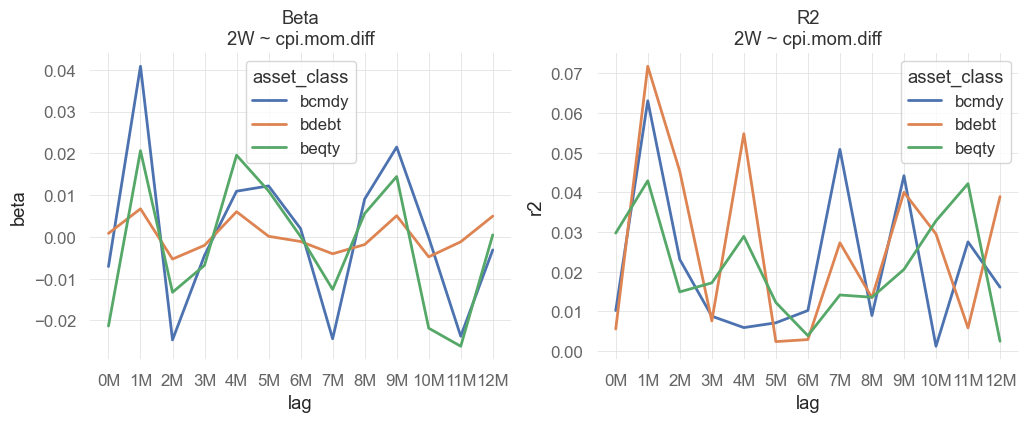

In [75]:
funcs.plot_ols_stats(df_cpi_diffs, dfret2w, dfetfref, nbetas, "cpi.mom.diff", title='2W')

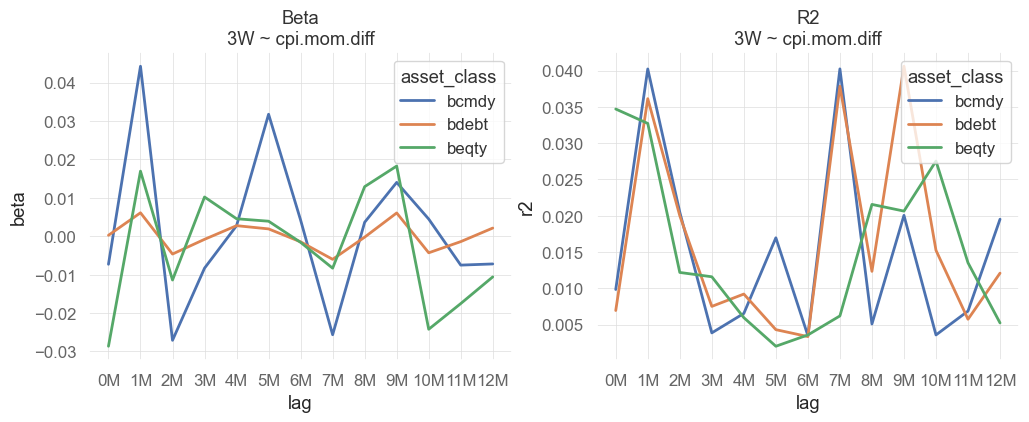

In [76]:
funcs.plot_ols_stats(df_cpi_diffs, dfret3w, dfetfref, nbetas, "cpi.mom.diff", title='3W')

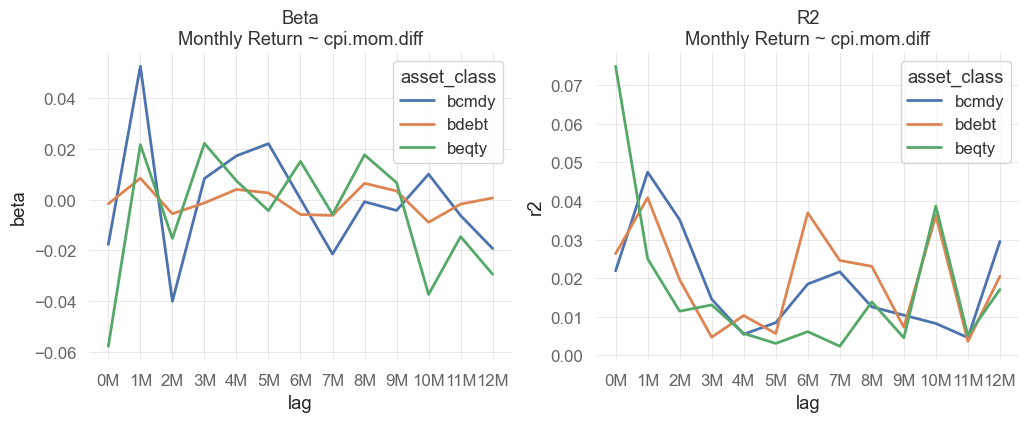

In [68]:
funcs.plot_ols_stats(df_cpi_diffs, dfret1m, dfetfref, nbetas, "cpi.mom.diff")

## Beta: Returns ~ YoY CPI

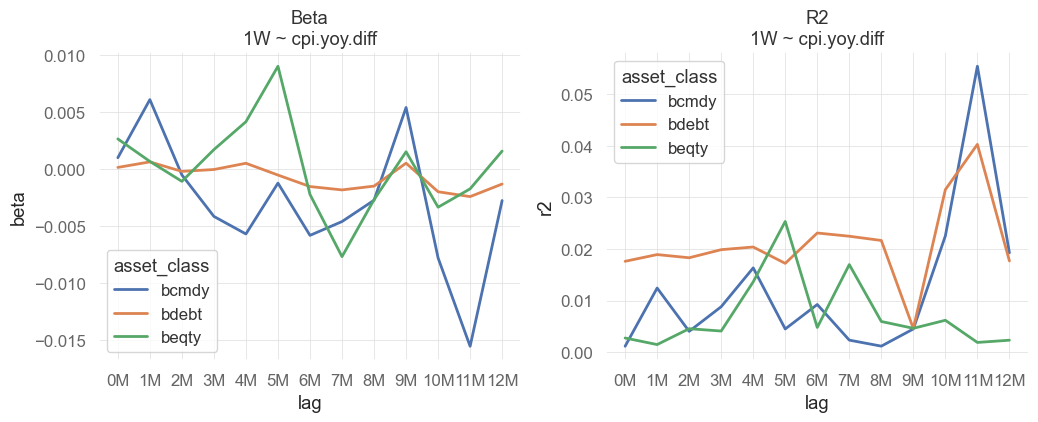

In [70]:
funcs.plot_ols_stats(df_cpi_diffs, dfret1w, dfetfref, nbetas, "cpi.yoy.diff", title="1W")

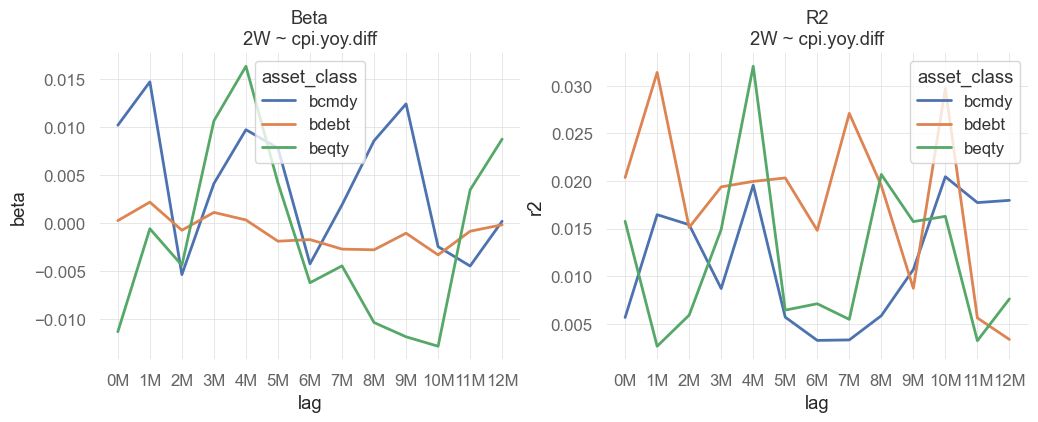

In [71]:
funcs.plot_ols_stats(df_cpi_diffs, dfret2w, dfetfref, nbetas, "cpi.yoy.diff", title="2W")

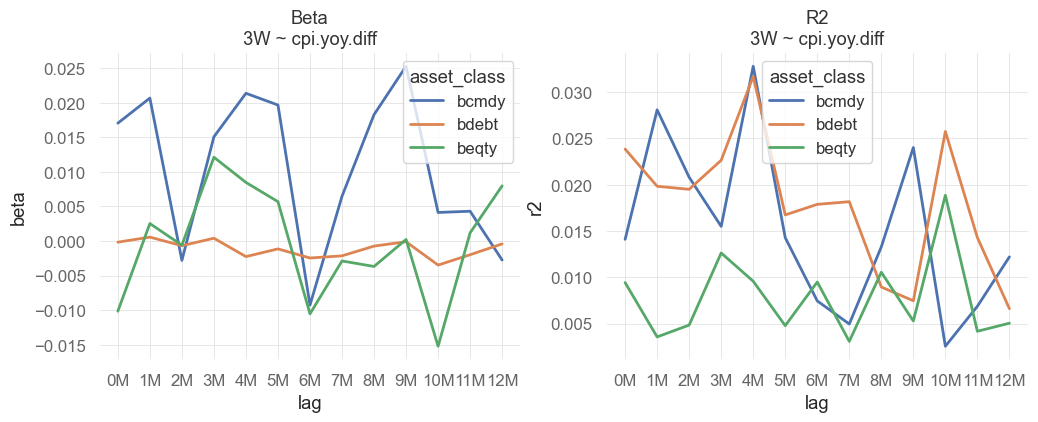

In [72]:
funcs.plot_ols_stats(df_cpi_diffs, dfret3w, dfetfref, nbetas, "cpi.yoy.diff", title="3W")

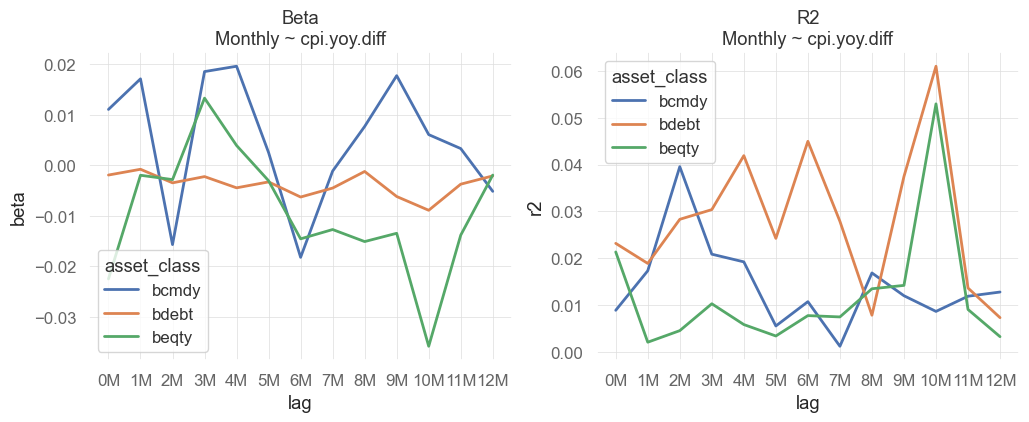

In [73]:
funcs.plot_ols_stats(df_cpi_diffs, dfret1m, dfetfref, nbetas, "cpi.yoy.diff", title="Monthly")

# Plots - CPI / ISM distributions

In [248]:
for c in dfism_man.columns:
    print(c)

# Examine relationship of changes in realized CPI to etf returns 
# Establish if there is a relationship that exists with real observed data to then compare with predictive power of turnleaf
# forecasts on etf returns
cols = ['usa.cpi.yoy.nsa.pubdate', 'usa.cpi.yoy.nsa.refdate', 'usa.cpi.yoy.nsa.realised', 'usa.cpi.mom.nsa.realised']
df = dfcpius[cols].dropna().reset_index().copy()
df['adjpubdate'] = df['usa.cpi.yoy.nsa.pubdate']
df.columns = ['idxdate', 'pubdate', 'refdate', 'cpi.yoy.actual', 'cpi.mom.actual', 'adjpubdate']
df.drop('idxdate', axis=1, inplace=True)
df = df[['pubdate', 'refdate', 'adjpubdate', 'cpi.yoy.actual', 'cpi.mom.actual']]

df['adjpubdate'] = df['adjpubdate'].apply(adj_date) # apply adjustment for dates prior to march 2020

df.head()

usa.tlbt.ism.manuf.1m
usa.tlbt.ism.manuf.2m
usa.tlbt.ism.manuf.3m
usa.tlbt.ism.manuf.4m
usa.tlbt.ism.manuf.5m
usa.tlbt.ism.manuf.6m
usa.tlbt.ism.manuf.7m
usa.tlbt.ism.manuf.8m
usa.tlbt.ism.manuf.9m
usa.tlbt.ism.manuf.10m
usa.tlbt.ism.manuf.11m
usa.tlbt.ism.manuf.12m
usa.tlbt.ism.manuf.date.1m
usa.tlbt.ism.manuf.date.2m
usa.tlbt.ism.manuf.date.3m
usa.tlbt.ism.manuf.date.4m
usa.tlbt.ism.manuf.date.5m
usa.tlbt.ism.manuf.date.6m
usa.tlbt.ism.manuf.date.7m
usa.tlbt.ism.manuf.date.8m
usa.tlbt.ism.manuf.date.9m
usa.tlbt.ism.manuf.date.10m
usa.tlbt.ism.manuf.date.11m
usa.tlbt.ism.manuf.date.12m
usa.ism.manuf.live
usa.ism.manuf.realised
usa.ism.manuf.realised.1m
usa.ism.manuf.realised.2m
usa.ism.manuf.realised.3m
usa.ism.manuf.realised.4m
usa.ism.manuf.realised.5m
usa.ism.manuf.realised.6m
usa.ism.manuf.realised.7m
usa.ism.manuf.realised.8m
usa.ism.manuf.realised.9m
usa.ism.manuf.realised.10m
usa.ism.manuf.realised.11m
usa.ism.manuf.realised.12m
usa.ism.manuf.pubdate
usa.ism.manuf.refdate
usa.t

In [55]:
dfcpi.tail()

,usa.tlbt.cpi.yoy.nsa.1m,usa.tlbt.cpi.yoy.nsa.2m,usa.tlbt.cpi.yoy.nsa.3m,usa.tlbt.cpi.yoy.nsa.4m,usa.tlbt.cpi.yoy.nsa.5m,usa.tlbt.cpi.yoy.nsa.6m,usa.tlbt.cpi.yoy.nsa.7m,usa.tlbt.cpi.yoy.nsa.8m,usa.tlbt.cpi.yoy.nsa.9m,usa.tlbt.cpi.yoy.nsa.10m,...,usa.tlbt.cons.cpi.mom.nsa.date.6m,usa.tlbt.cons.cpi.mom.nsa.date.7m,usa.tlbt.cons.cpi.mom.nsa.date.8m,usa.tlbt.cons.cpi.mom.nsa.date.9m,usa.tlbt.cons.cpi.mom.nsa.date.10m,usa.tlbt.cons.cpi.mom.nsa.date.11m,usa.tlbt.cons.cpi.mom.nsa.date.12m,pubdate,cpi.yoy.diff,cpi.mom.diff
index,,,,,,,,,,,,,,,,,,,,,
2022-07-13,9.024969,8.989747,9.128778,8.832738,8.284620,8.200565,8.023860,7.513991,6.656047,5.662177,...,2022-12-31,2023-01-31,2023-02-28,2023-03-31,2023-04-30,2023-05-31,2023-06-30,2022-07-13,0.478247,0.271255
2022-08-10,8.387462,8.438232,8.068756,7.861275,8.624025,8.312525,7.057991,5.526698,5.122575,4.760472,...,2023-01-31,2023-02-28,2023-03-31,2023-04-30,2023-05-31,2023-06-30,2023-07-31,2022-08-10,-0.534944,-1.385419
2022-09-13,7.856162,7.883540,7.026634,6.996877,6.454516,5.957937,5.368764,5.555147,5.664771,5.624766,...,2023-02-28,2023-03-31,2023-04-30,2023-05-31,2023-06-30,2023-07-31,2023-08-31,2022-09-13,-0.262122,-0.023628
2022-10-13,7.869834,7.399839,6.875868,6.636857,6.784738,5.501000,5.509504,4.773905,4.189337,4.432001,...,2023-03-31,2023-04-30,2023-05-31,2023-06-30,2023-07-31,2023-08-31,2023-09-30,2022-10-13,-0.061023,0.250518
2022-11-10,7.296720,7.205775,6.559795,5.670168,4.874607,5.082720,3.766814,3.804590,3.205873,3.277057,...,2023-04-30,2023-05-31,2023-06-30,2023-07-31,2023-08-31,2023-09-30,2023-10-31,2022-11-10,-0.456243,0.190571


<Axes: >

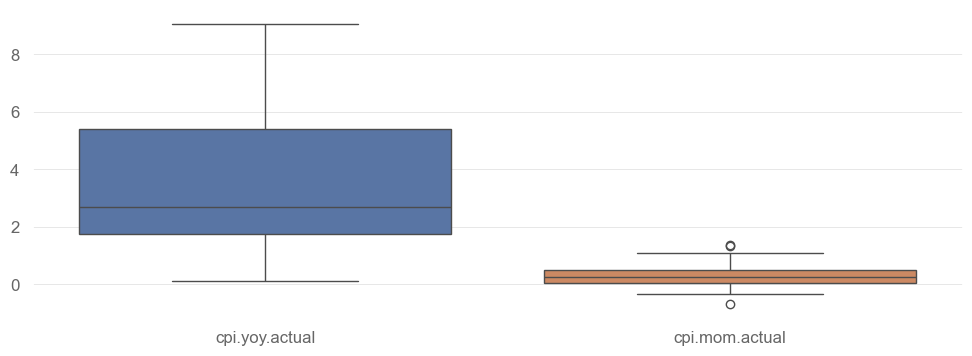

In [82]:
sb.boxplot(df[['cpi.yoy.actual', 'cpi.mom.actual']])

In [83]:
df[['cpi.yoy.actual', 'cpi.mom.actual']].describe()

,cpi.yoy.actual,cpi.mom.actual
count,69.000000,69.000000
mean,3.759291,0.314442
std,2.528708,0.379352
min,0.117926,-0.668694
25%,1.764043,0.055554
50%,2.699180,0.271597
75%,5.391451,0.505904
max,9.059758,1.373608


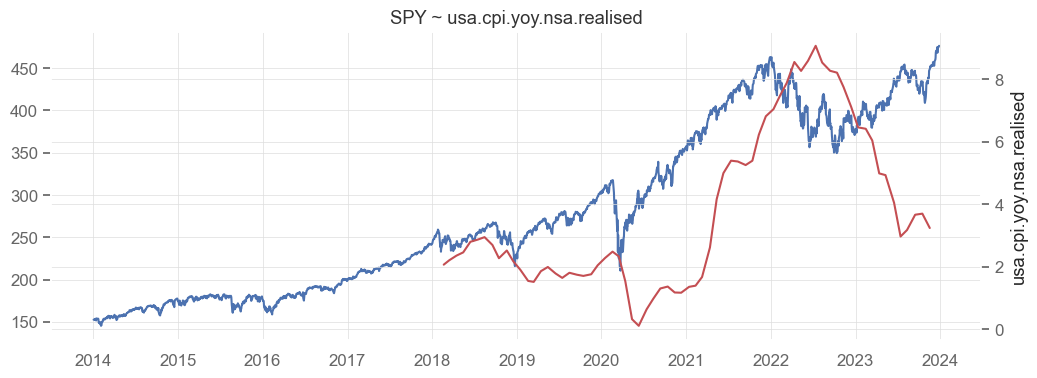

In [214]:

etf = 'SPY'
xcol = 'usa.cpi.yoy.nsa.realised'

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(dfcloses.index, dfcloses[etf]);
sb.lineplot(data=dfcpi, x='pubdate', y=xcol, ax=ax2, color='r');
plt.title(f"{etf} ~ {xcol}");


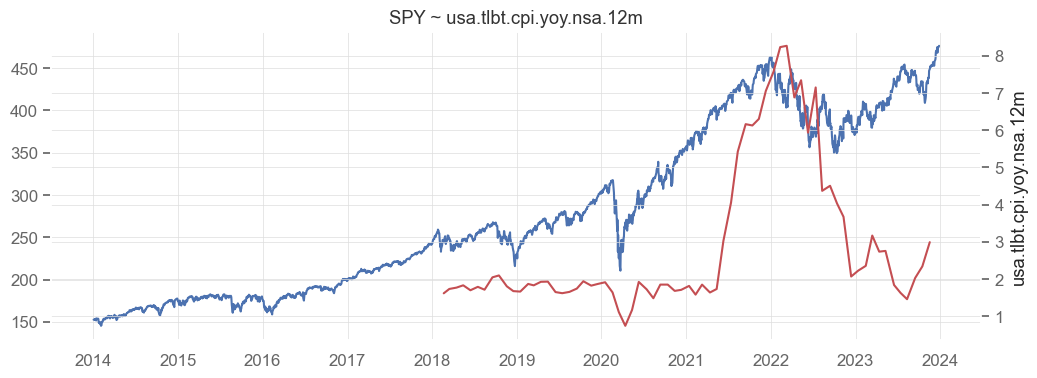

In [206]:
etf = 'SPY'
# xcol = 'usa.cpi.yoy.nsa.realised'
xcol = 'usa.tlbt.cpi.yoy.nsa.12m'

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(dfcloses.index, dfcloses[etf]);
sb.lineplot(data=dfcpi, x='pubdate', y=xcol, ax=ax2, color='r');
plt.title(f"{etf} ~ {xcol}");


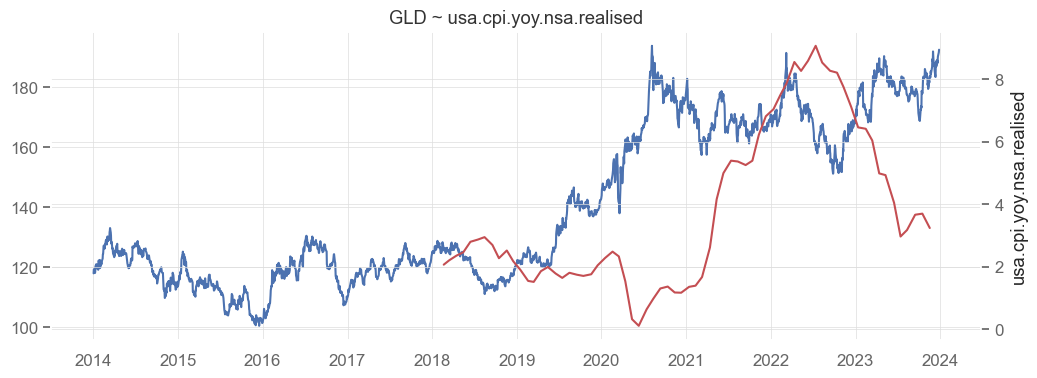

In [213]:
etf = 'GLD'
xcol = 'usa.cpi.yoy.nsa.realised'
# xcol = 'usa.tlbt.cpi.yoy.nsa.12m'

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(dfcloses.index, dfcloses[etf]);
sb.lineplot(data=dfcpi, x='pubdate', y=xcol, ax=ax2, color='r');
plt.title(f"{etf} ~ {xcol}");


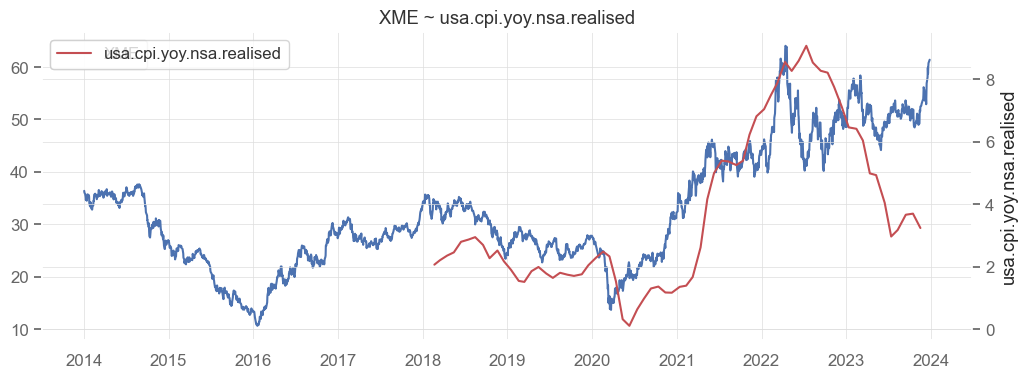

In [211]:
etf = 'XME'
xcol = 'usa.cpi.yoy.nsa.realised'

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(dfcloses.index, dfcloses[etf], label=etf);
ax1.legend();
sb.lineplot(data=dfcpi, x='pubdate', y=xcol, ax=ax2, color='r', label=xcol);
ax2.legend();
# plt.legend([etf, xcol]);
plt.title(f"{etf} ~ {xcol}");

In [125]:
df.head()

,pubdate,refdate,adjpubdate,cpi.yoy.actual,cpi.mom.actual,trd.entry,trd.exit1w,trd.exit2w,trd.exit3w,trd.exit1m,cpi.yoy.diff,cpi.mom.diff
1,2018-03-13,2018-02-28,2018-03-16,2.211795,0.453469,2018-03-16,2018-03-23,2018-03-29,2018-04-06,2018-04-13,0.141288,-0.091306
2,2018-04-11,2018-03-31,2018-04-16,2.359711,0.226113,2018-04-16,2018-04-23,2018-04-30,2018-05-07,2018-05-14,0.147916,-0.227356
3,2018-05-10,2018-04-30,2018-05-15,2.462744,0.397509,2018-05-15,2018-05-22,2018-05-29,2018-06-05,2018-06-14,0.103033,0.171397
4,2018-06-12,2018-05-31,2018-06-15,2.801012,0.415892,2018-06-15,2018-06-22,2018-06-29,2018-07-06,2018-07-16,0.338268,0.018383
5,2018-07-12,2018-06-30,2018-07-17,2.871548,0.159388,2018-07-17,2018-07-24,2018-07-31,2018-08-07,2018-08-14,0.070536,-0.256504


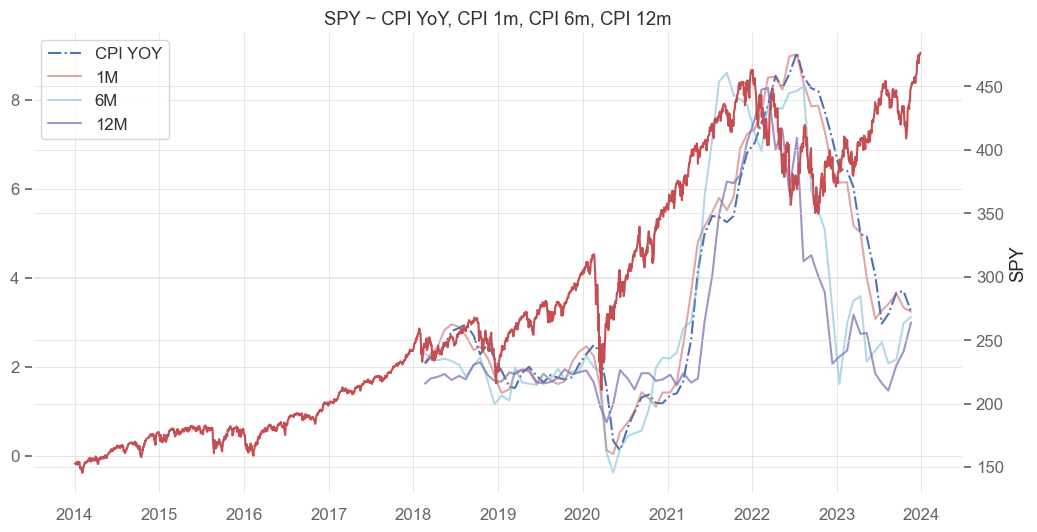

In [246]:
plt.rcParams['figure.figsize'] =  [12, 6]
etf = 'SPY'

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
# ax3 = ax1.twinx()
# ax4 = ax1.twinx()
# ax5 = ax1.twinx()


ax1.plot(dfcpi['pubdate'], dfcpi['usa.cpi.yoy.nsa.realised'], 'b-.', label='CPI YOY');
ax1.legend();
ax1.plot(dfcpi['pubdate'], dfcpi['usa.tlbt.cpi.yoy.nsa.1m'], 'r', label='1M', alpha=.5);
ax1.legend();
# ax1.plot(dfcpi['pubdate'], dfcpi['usa.tlbt.cpi.yoy.nsa.3m'], 'g', label='3M', alpha=.5);
# ax1.legend();
ax1.plot(dfcpi['pubdate'], dfcpi['usa.tlbt.cpi.yoy.nsa.6m'], 'c', label='6M', alpha=.5);
ax1.legend();
ax1.plot(dfcpi['pubdate'], dfcpi['usa.tlbt.cpi.yoy.nsa.12m'], 'm', label='12M', alpha=.75);
ax1.legend();

sb.lineplot(data=dfcloses, x=dfcloses.index, y=etf, ax=ax2, color='r');

plt.title(f"{etf} ~ CPI YoY, CPI 1m, CPI 6m, CPI 12m");

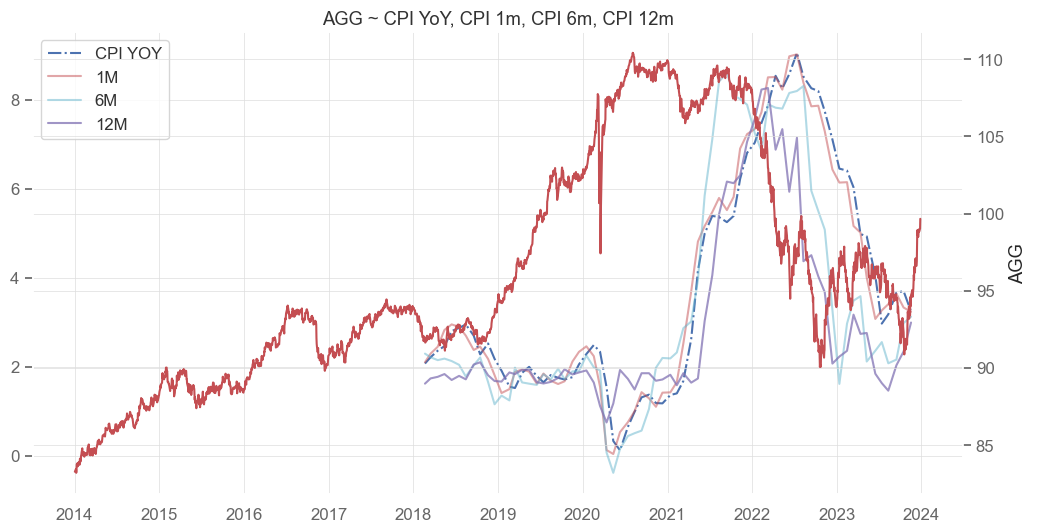

In [256]:
plt.rcParams['figure.figsize'] =  [12, 6]
etf = 'AGG'

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(dfcpi['pubdate'], dfcpi['usa.cpi.yoy.nsa.realised'], 'b-.', label='CPI YOY');
ax1.legend();
ax1.plot(dfcpi['pubdate'], dfcpi['usa.tlbt.cpi.yoy.nsa.1m'], 'r', label='1M', alpha=.5);
ax1.legend();
# ax1.plot(dfcpi['pubdate'], dfcpi['usa.tlbt.cpi.yoy.nsa.3m'], 'g', label='3M', alpha=.5);
# ax1.legend();
ax1.plot(dfcpi['pubdate'], dfcpi['usa.tlbt.cpi.yoy.nsa.6m'], 'c', label='6M', alpha=.5);
ax1.legend();
ax1.plot(dfcpi['pubdate'], dfcpi['usa.tlbt.cpi.yoy.nsa.12m'], 'm', label='12M', alpha=.75);
ax1.legend();

sb.lineplot(data=dfcloses, x=dfcloses.index, y=etf, ax=ax2, color='r');

plt.title(f"{etf} ~ CPI YoY, CPI 1m, CPI 6m, CPI 12m");

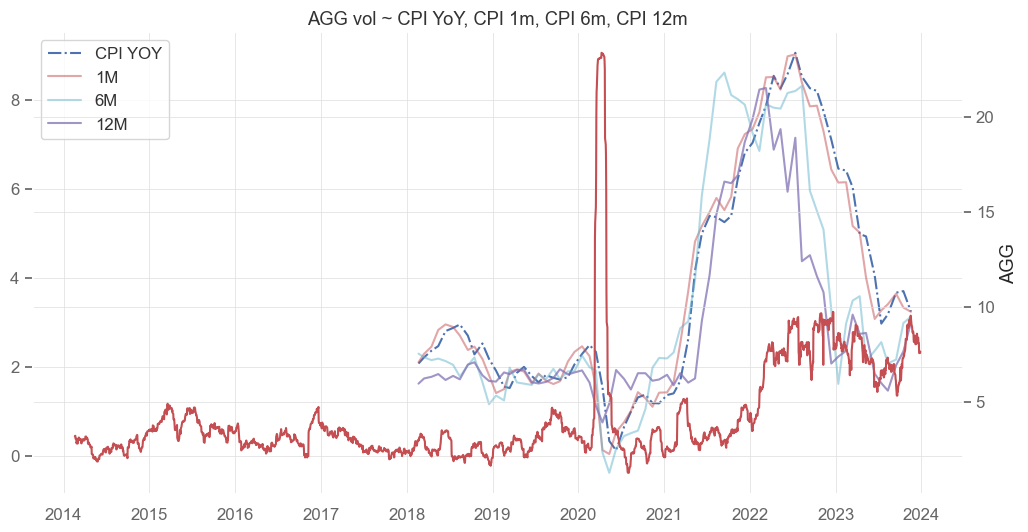

In [255]:
# Look at VOLs ~ CPI
plt.rcParams['figure.figsize'] =  [12, 6]
etf = 'AGG'

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(dfcpi['pubdate'], dfcpi['usa.cpi.yoy.nsa.realised'], 'b-.', label='CPI YOY');
ax1.legend();
ax1.plot(dfcpi['pubdate'], dfcpi['usa.tlbt.cpi.yoy.nsa.1m'], 'r', label='1M', alpha=.5);
ax1.legend();
# ax1.plot(dfcpi['pubdate'], dfcpi['usa.tlbt.cpi.yoy.nsa.3m'], 'g', label='3M', alpha=.5);
# ax1.legend();
ax1.plot(dfcpi['pubdate'], dfcpi['usa.tlbt.cpi.yoy.nsa.6m'], 'c', label='6M', alpha=.5);
ax1.legend();
ax1.plot(dfcpi['pubdate'], dfcpi['usa.tlbt.cpi.yoy.nsa.12m'], 'm', label='12M', alpha=.75);
ax1.legend();

sb.lineplot(data=stdev_30d, x=stdev_30d.index, y=etf, ax=ax2, color='r');

plt.title(f"{etf} vol ~ CPI YoY, CPI 1m, CPI 6m, CPI 12m");

In [249]:
stdev_30d

ticker,SPY,AGG,XOP,XME,XHB,GLD,BIL,TIP,SPTS,SPTI
2014-02-18,14.11,3.18,22.89,23.15,21.31,14.35,0.25,4.63,3.31,2.38
2014-02-19,14.23,3.19,22.96,23.40,20.67,14.71,0.25,4.61,3.29,2.38
2014-02-20,14.22,3.20,22.84,23.52,20.83,14.73,0.24,4.72,3.28,2.40
2014-02-21,14.22,3.04,22.78,23.51,20.80,14.54,0.25,4.73,3.16,2.26
2014-02-24,14.31,3.05,23.73,22.95,20.51,14.75,0.25,4.61,3.16,2.27
...,...,...,...,...,...,...,...,...,...,...
2023-12-20,10.47,8.08,24.56,27.65,27.42,15.25,0.24,7.36,2.64,6.77
2023-12-21,10.65,8.08,23.94,27.82,27.40,14.97,0.27,7.40,2.64,6.78
2023-12-22,10.18,7.56,23.83,27.50,26.75,14.98,0.26,6.90,2.55,6.38
2023-12-26,9.47,7.56,24.03,27.50,26.48,14.59,0.26,6.90,2.55,6.39
